In [1]:
import re

# Function to parse the log file and save each run's DBN and Defect Prediction data in separate files
def parse_and_save_runs(input_file):
    with open(input_file, 'r') as file:
        content = file.read()

    # Regular expression to capture each run
    runs = re.split(r'Run \d+:', content)[1:]  # Splits content by each run and skips the initial empty split

    for index, run in enumerate(runs, start=1):
        # Extract DBN part
        dbn_match = re.search(
            r"DBN Classification Report.*?Confusion Matrix:\s*\[\[.*?\]\]\s*DBN AUC Score: (.*?)\s*DBN Accuracy Score: (.*?)\s",
            run, re.DOTALL)
        
        # Extract Defect Prediction part
        defect_match = re.search(
            r"Defect Prediction Classification Report.*?Confusion Matrix:\s*\[\[.*?\]\]\s*Defect Prediction AUC Score: (.*?)\s*Defect Prediction Accuracy Score: (.*?)\s",
            run, re.DOTALL)
        
        if dbn_match:
            # DBN extracted components
            dbn_text = dbn_match.group(0)  # Full match
            dbn_auc = dbn_match.group(1)
            dbn_accuracy = dbn_match.group(2)
            
            # Format the DBN part
            dbn_text_formatted = re.sub(
                r"DBN Classification Report.*?for.*?dataset:", "classification report:", dbn_text, flags=re.DOTALL
            )
            dbn_text_formatted = re.sub(
                r"DBN Confusion Matrix:", "confusion matrix:", dbn_text_formatted
            )
            dbn_text_formatted = re.sub(
                r"DBN AUC Score:", "auc:", dbn_text_formatted
            )
            dbn_text_formatted = re.sub(
                r"DBN Accuracy Score:", "accuracy:", dbn_text_formatted
            )
            dbn_text_formatted = f"Final selected actions: DBN\n{dbn_text_formatted}"
            
            # Save DBN to file
            with open(f"DBN-{index}.txt", "w") as dbn_file:
                dbn_file.write(dbn_text_formatted)
        
        if defect_match:
            # Defect Prediction extracted components
            defect_text = defect_match.group(0)  # Full match
            defect_auc = defect_match.group(1)
            defect_accuracy = defect_match.group(2)
            
            # Format the Defect Prediction part
            defect_text_formatted = re.sub(
                r"Defect Prediction Classification Report.*?for.*?dataset:", "classification report:", defect_text, flags=re.DOTALL
            )
            defect_text_formatted = re.sub(
                r"Defect Prediction Confusion Matrix:", "confusion matrix:", defect_text_formatted
            )
            defect_text_formatted = re.sub(
                r"Defect Prediction AUC Score:", "auc:", defect_text_formatted
            )
            defect_text_formatted = re.sub(
                r"Defect Prediction Accuracy Score:", "accuracy:", defect_text_formatted
            )            
            defect_text_formatted = f"Final selected actions: DBNB\n{defect_text_formatted}"
            
            # Save Defect Prediction to file
            with open(f"DBNB-{index}.txt", "w") as defect_file:
                defect_file.write(defect_text_formatted)

# Example usage
parse_and_save_runs("baselines.txt")


In [3]:
import os
import re
import pandas as pd

# Directory containing text files
input_directory = '../results'
output_csv = 'results2.csv'

# Regex patterns to extract required values
patterns = {
    'Final selected actions': re.compile(r"Final selected actions: \{([^\}]*)\}"),
    'Accuracy': re.compile(r"accuracy: ([\d.]+)"),
    'AUC': re.compile(r"auc: ([\d.]+)"),
    'Confusion Matrix': re.compile(r"confusion matrix: \[\[(\d+)\s+(\d+)\]\s+\[\s+(\d+)\s+(\d+)\]\]"),
    'Precision 0': re.compile(r"0\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)"),
    'Precision 1': re.compile(r"1\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)"),
    'Precision mac' : re.compile(r"macro avg\s+(\d+\.\d+)\s+(\d+\.\d+)\s+(\d+\.\d+)"),
}

# Initialize data list
data = []

# Read each text file in the directory
for filename in os.listdir(input_directory):
    if filename.endswith(".txt"):
        with open(os.path.join(input_directory, filename), 'r') as file:
            content = file.read()
            
            # Extract values
            final_actions = patterns['Final selected actions'].search(content)
            accuracy = patterns['Accuracy'].search(content)
            auc = patterns['AUC'].search(content)
            confusion_matrix = patterns['Confusion Matrix'].search(content)
            precision_0 = patterns['Precision 0'].search(content)
            precision_1 = patterns['Precision 1'].search(content)
            precision_mac = patterns['Precision mac'].search(content)
            
            # Get values or set to None if not found
            final_actions = final_actions.group(1) if final_actions else ""
            accuracy = float(accuracy.group(1)) if accuracy else None
            auc = float(auc.group(1)) if auc else None
            tp, fp, fn, tn = (int(confusion_matrix.group(i)) for i in range(1, 5)) if confusion_matrix else (None, None, None, None)
            
            # Classification report metrics
            precision_0_val = float(precision_0.group(1)) if precision_0 else None
            recall_0 = float(precision_0.group(2)) if precision_0 else None
            f1_0 = float(precision_0.group(3)) if precision_0 else None
            precision_1_val = float(precision_1.group(1)) if precision_1 else None
            recall_1 = float(precision_1.group(2)) if precision_1 else None
            f1_1 = float(precision_1.group(3)) if precision_1 else None
            precision_m_val = float(precision_mac.group(1)) if precision_mac else None
            recall_m = float(precision_mac.group(2)) if precision_mac else None
            f1_m = float(precision_mac.group(3)) if precision_mac else None
            
            # Calculate overall Recall, F1-score, FP, FN, and FP + FN
            recall = recall_m  # Assuming we want the recall of class 1
            f1 = f1_m          # Assuming we want the f1-score of class 1
            fp_fn_sum = (fp or 0) + (fn or 0)
            if "cph2" in filename:
                mode = "cph2"
            elif "sph2" in filename:
                mode = "sph2"
            elif "simple-ph" in filename:
                mode = "simple_ph"
            elif "simple" in filename:
                mode = "simple"
            elif "ph" in filename:
                mode = "custom_ph"
            elif "setting" in filename:
                mode = filename
            elif "DBNB" in filename:
                mode = "DBNB"
            elif "DBN" in filename:
                mode = "DBN"
            elif "ALL" in filename:
                mode = "ALL"
            elif "baselines" in filename:
                continue
            else:
                mode = "custom"
            # Append row data
            data.append({
                'mode': mode,
                'Final Selected Actions': final_actions,
                'Accuracy': accuracy,
                'AUC': auc,
                'TP': tp,
                'TN': tn,
                'FP': fp,
                'FN': fn,
                'Precision': precision_m_val,
                'Recall': recall,
                'F1': f1,
                'FP + FN': fp_fn_sum
            })

# Create a DataFrame and save to CSV
df = pd.DataFrame(data)
df.to_csv(output_csv, index=False)
print(f"Data saved to {output_csv}")


Data saved to results2.csv


In [5]:
import pandas as pd
def change_mode(mode):
    if mode == "sph2":
        return  "simple-pheromone-2"
    elif mode == "cph2":
        return "custom-pheromone-2"
    elif mode == "simple_ph":
        return "simple-pheromone"
    elif mode == "custom_ph":
        return "custom-pheromone"
    else:
        return mode

df = pd.read_csv('results.csv')
df["mode"].apply(change_mode)

0                    ALL
1     custom-pheromone-2
2     custom-pheromone-2
3     custom-pheromone-2
4     custom-pheromone-2
             ...        
78    simple-pheromone-2
79    simple-pheromone-2
80    simple-pheromone-2
81    simple-pheromone-2
82    simple-pheromone-2
Name: mode, Length: 83, dtype: object

In [6]:
import pandas as pd

# Define the custom order
custom_order = ['custom-pheromone-2', 'simple-pheromone', 'custom-pheromone', 'simple-pheromone-2', 'custom', 'simple']

# Convert 'mode' column to categorical with the custom order
df['mode'] = pd.Categorical(df['mode'], categories=custom_order, ordered=True)

# Sort the DataFrame by the 'mode' column
sorted_df = df.sort_values(by='mode')

print(sorted_df)


      mode                             Final Selected Actions  Accuracy  \
10  custom  2306, 1051, 2844, 157, 284, 3112, 2224, 2870, ...  0.900524   
11  custom  1417, 1040, 3608, 1049, 3238, 680, 425, 813, 2...  0.906507   
12  custom  3602, 3352, 3359, 2211, 3364, 1836, 2863, 2873...  0.900524   
13  custom  151, 924, 548, 169, 2610, 1076, 2488, 3256, 26...  0.902767   
14  custom  1031, 2068, 2976, 1700, 175, 819, 3774, 448, 1...  0.908751   
..     ...                                                ...       ...   
78     NaN  1, 33, 34, 4, 5, 6, 35, 8, 10, 11, 13, 14, 17,...  0.902019   
79     NaN  0, 34, 4, 5, 9, 10, 11, 13, 14, 15, 17, 20, 21...  0.902019   
80     NaN  1, 2, 3, 4, 5, 7, 8, 10, 12, 15, 17, 18, 20, 2...  0.911743   
81     NaN  0, 1, 2, 4, 5, 6, 10, 11, 12, 13, 14, 15, 17, ...  0.912491   
82     NaN  0, 3, 4, 7, 8, 9, 11, 12, 13, 18, 19, 23, 24, ...  0.903515   

         AUC      TP    TN    FP    FN  Precision  Recall    F1  FP + FN  
10  0.858230  1166.0  38

C:\Users\USER\AppData\Local\Temp\ipykernel_1248\387048157.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["mode"] = df_filtered["mode"].apply(change_mode)
C:\Users\USER\AppData\Local\Temp\ipykernel_1248\387048157.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['mode'] = pd.Categorical(df_filtered['mode'], categories=custom_order, ordered=True)


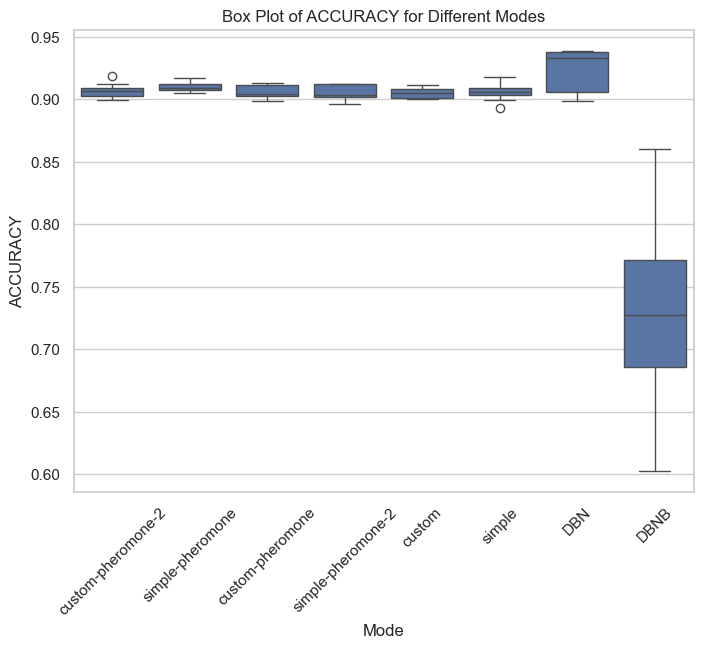

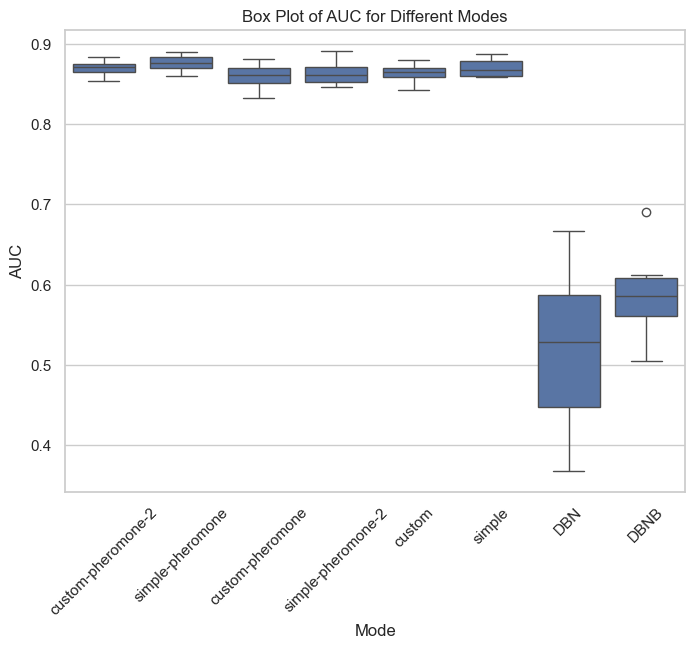

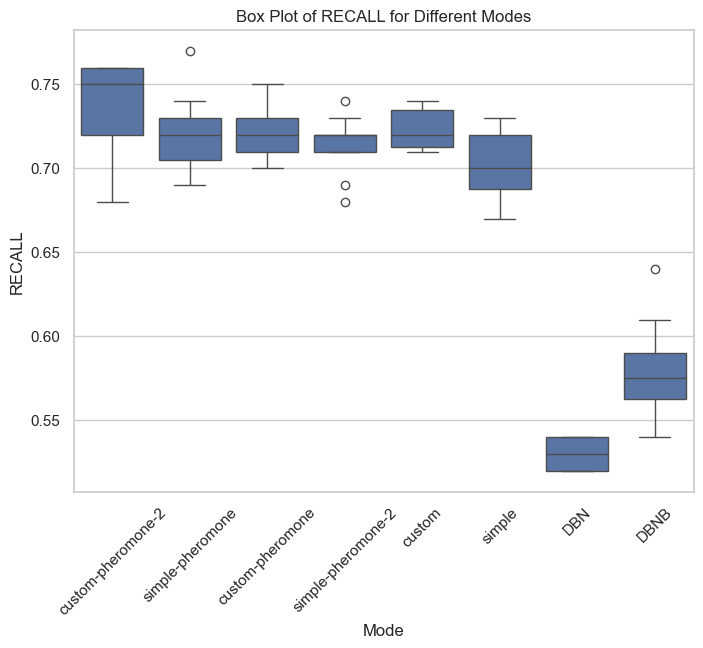

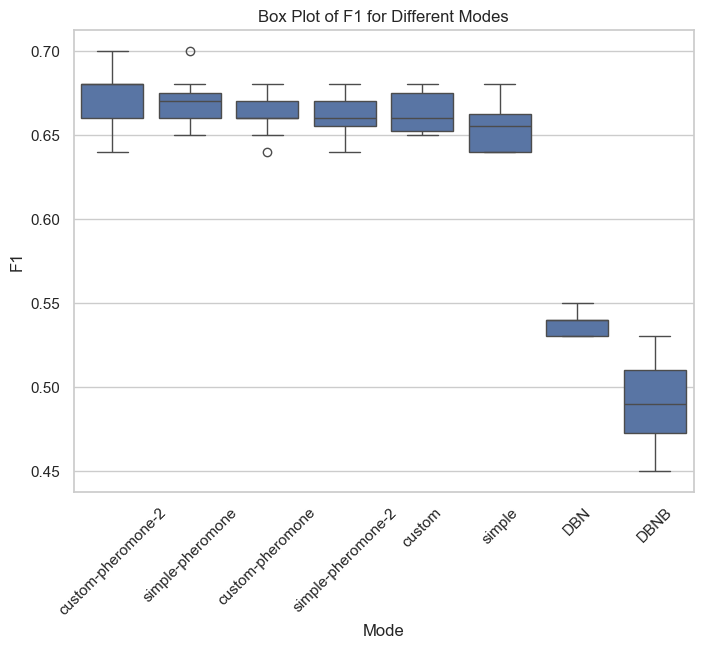

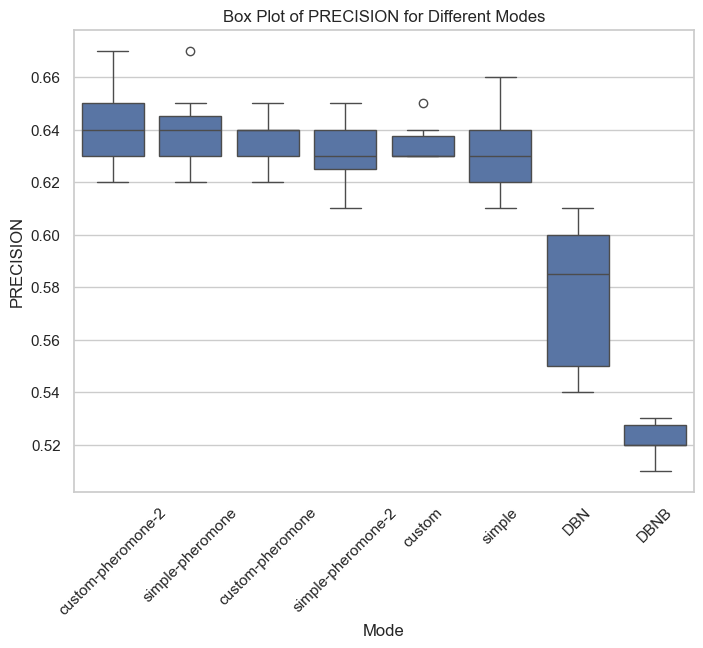

In [62]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv("results.csv")  # Replace with your actual CSV file path

# Set up the plotting style
sns.set(style="whitegrid")

# Filter the data to only include the specified settings
settings = ["simple", "custom", "cph2", "sph2", "simple_ph", "custom_ph", "DBN", "DBNB"]
df_filtered = df[df['mode'].isin(settings)]
df_filtered["mode"] = df_filtered["mode"].apply(change_mode)

# Define the custom order
custom_order = ['custom-pheromone-2', 'simple-pheromone', 'custom-pheromone', 'simple-pheromone-2', 'custom', 'simple', 'DBN', 'DBNB']

# Convert 'mode' column to categorical with the custom order
df_filtered['mode'] = pd.Categorical(df_filtered['mode'], categories=custom_order, ordered=True)

# Sort the DataFrame by the 'mode' column
df_filtered = df_filtered.sort_values(by='mode')

# Plot each metric separately in box plots
metrics = ['Accuracy','AUC', 'Recall', 'F1', 'Precision']
for metric in metrics:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_filtered, x="mode", y=metric)
    plt.title(f"Box Plot of {metric.upper()} for Different Modes")
    plt.xlabel("Mode")
    plt.ylabel(metric.upper())
    plt.xticks(rotation=45)

    plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_1248\3461201135.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_setting_num['NUM'] = pd.to_numeric(df_setting_num['mode'].str.extract(r'(\d+)')[0])


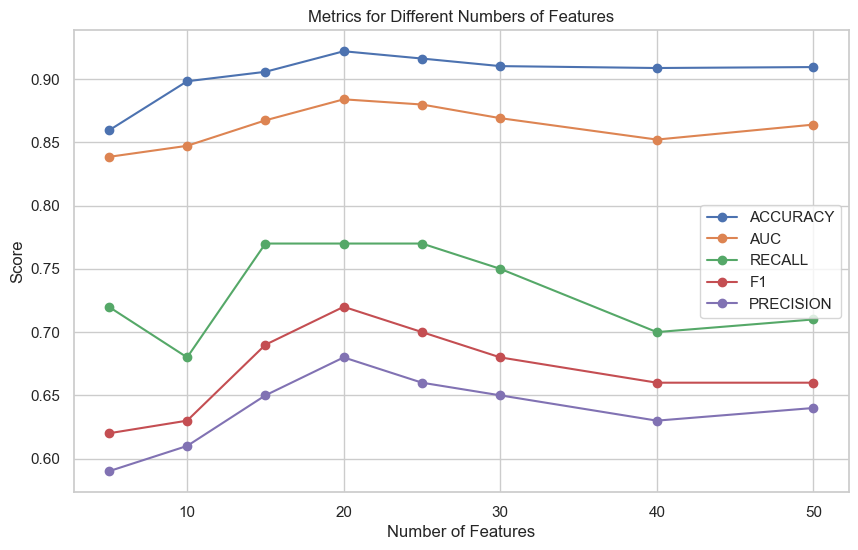

In [63]:
# Filter out rows that contain 'setting-NUM' as the mode
df_setting_num = df[df['mode'].str.startswith("setting")]

# Set NUM column as numeric (assuming it's either directly as a column or can be extracted from 'mode' column)
df_setting_num['NUM'] = pd.to_numeric(df_setting_num['mode'].str.extract(r'(\d+)')[0])

# Sort by NUM for better plotting
df_setting_num = df_setting_num.sort_values('NUM')

# Plot each metric for 'setting-NUM' with NUM on the X-axis
plt.figure(figsize=(10, 6))
for metric in metrics:
    plt.plot(df_setting_num['NUM'], df_setting_num[metric], marker='o', label=metric.upper())
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.title("Metrics for Different Numbers of Features")
plt.legend()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_1248\977344174.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df2.groupby('mode').apply(lambda x: x.sample(n=min(samples_per_mode, len(x)), random_state=10)).reset_index(drop=True)


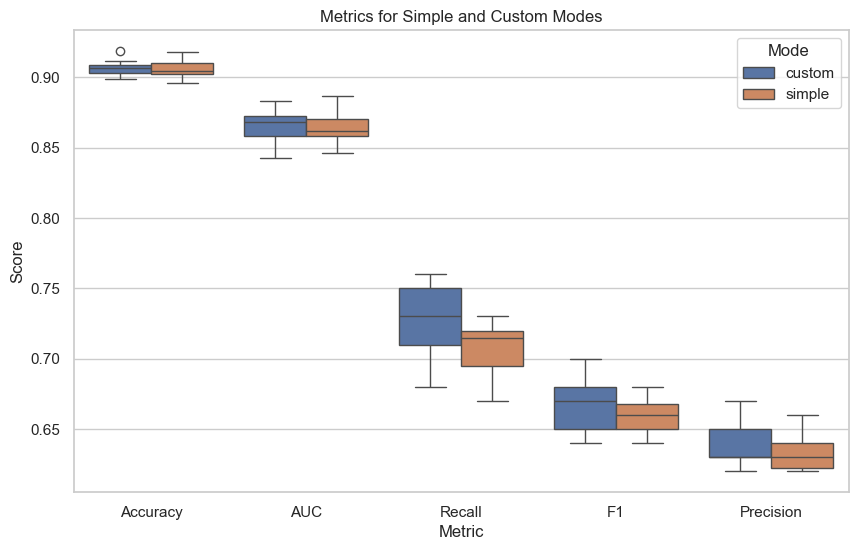

In [64]:
# Filter data for 'simple' and 'custom' modes
df2 = df.copy()
def rename_mode(x):
    if x == 'sph2':
        return 'simple'
    elif x == 'cph2':
        return 'custom'
    elif x == 'simple-ph':
        return 'simple'
    elif x == 'custom-ph':
        return 'custom'
    else:
        return x

samples_per_mode = 7
sampled_df = df2.groupby('mode').apply(lambda x: x.sample(n=min(samples_per_mode, len(x)), random_state=10)).reset_index(drop=True)
df2 = sampled_df

df2["mode"] = df2["mode"].apply(rename_mode)
df_simple_custom = df2[df2['mode'].isin(['simple', 'custom'])]

# Plotting F1 and AUC scores
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.melt(df_simple_custom, id_vars=['mode'], value_vars=['Accuracy','AUC', 'Recall', 'F1', 'Precision']), x='variable', y='value', hue='mode')
plt.title("Metrics for Simple and Custom Modes")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend(title="Mode")
plt.show()


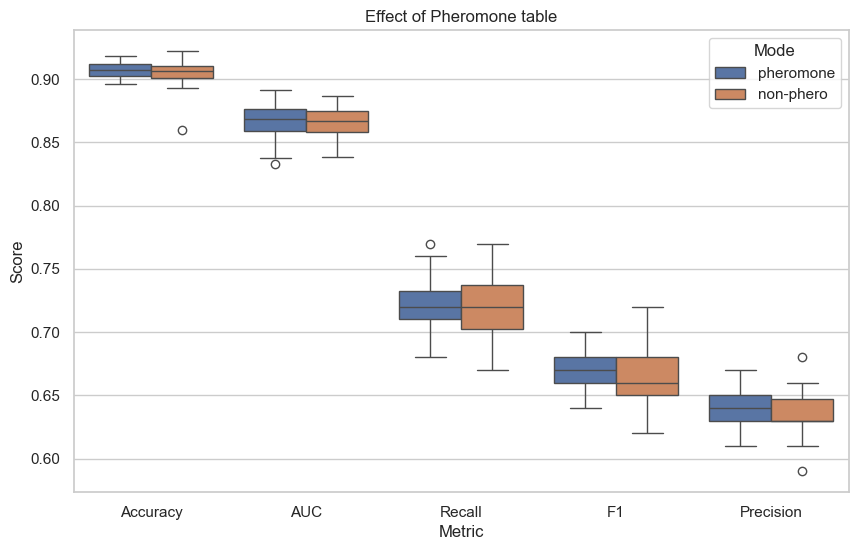

In [71]:
# Filter data for 'simple' and 'custom' modes
df2 = df.copy()
def rename_mode(x):
    if 'ph' in x:
        return 'pheromone'
    elif 'DBN' in x:
        return 'DBN'
    elif 'ALL' in x:
        return 'ALL'
    else:
        return "non-phero"
    
    
# samples_per_mode = 6
# sampled_df = df2.groupby('mode').apply(lambda x: x.sample(n=min(samples_per_mode, len(x)), random_state=42)).reset_index(drop=True)
# df2 = sampled_df

df2["mode"] = df2["mode"].apply(rename_mode)
df_simple_custom = df2[df2['mode'].isin(['pheromone', 'non-phero'])]

# Plotting F1 and AUC scores
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.melt(df_simple_custom, id_vars=['mode'], value_vars=['Accuracy','AUC', 'Recall', 'F1', 'Precision']), x='variable', y='value', hue='mode')
plt.title("Effect of Pheromone table")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend(title="Mode")
plt.show()


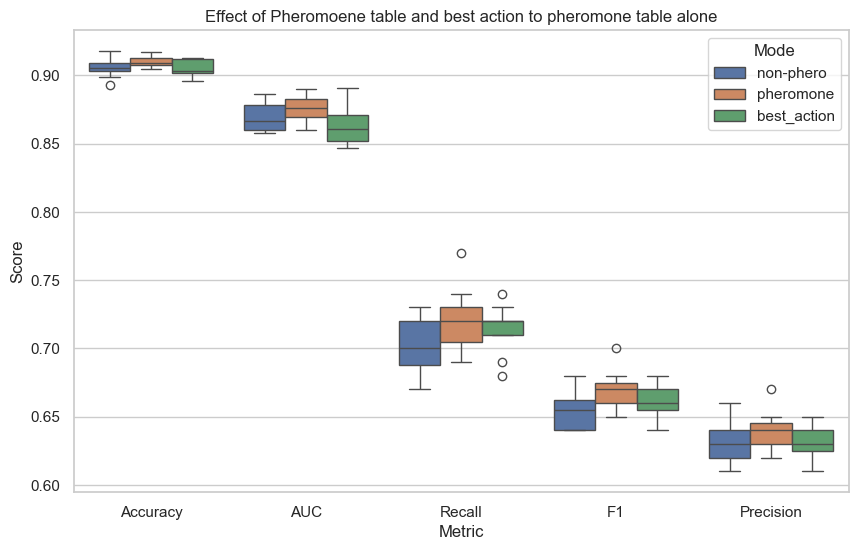

In [73]:
# Filter data for 'simple' and 'custom' modes
df2 = df.copy()
def rename_mode(x):
    if 'ph2' in x:
        return 'best_action'
    elif 'ph' in x:
        return 'pheromone'
    elif 'DBN' in x:
        return 'DBN'
    elif "ALL" in x:
        return "ALL"
    else:
        return "non-phero"

# samples_per_mode = 6
# sampled_df = df2.groupby('mode').apply(lambda x: x.sample(n=min(samples_per_mode, len(x)), random_state=42)).reset_index(drop=True)
# df2 = sampled_df
df2 = df2[df2["mode"].str.contains('simple|sph')]
df2["mode"] = df2["mode"].apply(rename_mode)
df_simple_custom = df2[df2['mode'].isin(['pheromone', 'best_action', 'non-phero'])]
df_simple_custom

# Plotting F1 and AUC scores
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.melt(df_simple_custom, id_vars=['mode'], value_vars=['Accuracy','AUC', 'Recall', 'F1', 'Precision']), x='variable', y='value', hue='mode')
plt.title("Effect of Pheromoene table and best action to pheromone table alone")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.legend(title="Mode")
plt.show()


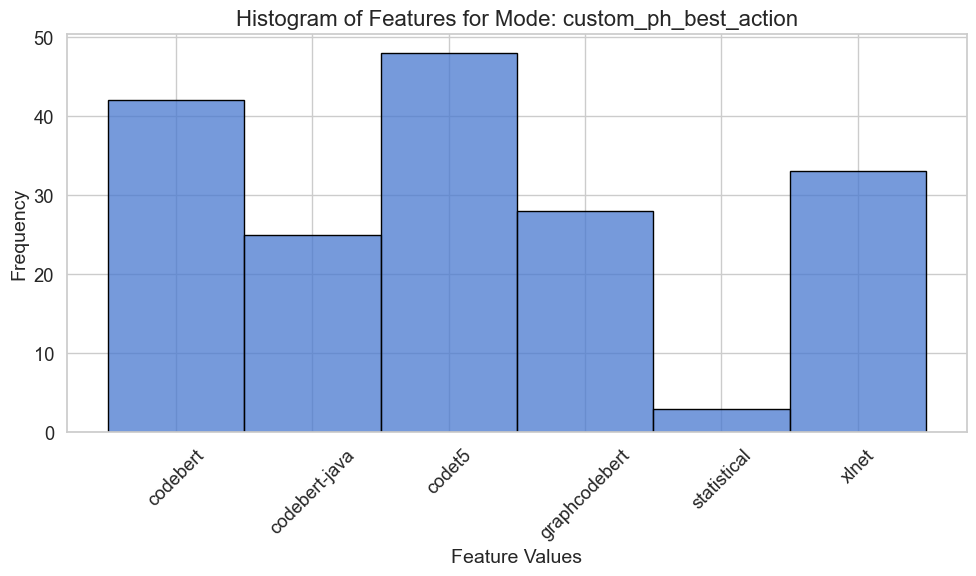

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


df = pd.read_csv('source_based_results.csv')
# Group by 'mode', map feature indices to names, and create histograms

df["Final Selected Actions"] = df["Final Selected Actions"].apply(lambda x: [str(y.replace("\'","").replace(" ","")) for y in x.split('[')[1].split(']')[0].split(',')])
df["mode"] = df["mode"].apply(lambda x: "custom_ph_best_action" if x == "cph2" else x)
df = df[df["mode"] == "custom_ph_best_action"]
mode_groups = df.groupby("mode")["Final Selected Actions"]

# Set style for publication quality
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

for mode, feature_names in mode_groups:
    extended_list = []
    for features in feature_names:
        extended_list.extend(features)

    # Create the histogram using Seaborn
    plt.figure(figsize=(10, 6))
    sns.histplot(sorted(extended_list), bins=30, kde=False, color="b", edgecolor="black")
    
    # Titles and labels with enhanced clarity
    plt.title(f"Histogram of Features for Mode: {mode}", fontsize=16)
    plt.xlabel("Feature Values", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    
    # Rotate x-ticks for better readability
    plt.xticks(rotation=45)
    
    # Tight layout to avoid clipping
    plt.tight_layout()
    plt.show()
